# Image Classification using Deep CNN

**Setup and load data**

**1. Install Dependencies and Setup**

In [ ]:
#!pip install tensorflow-gpu==2.11.0

In [ ]:
import cv2
import imghdr
import tensorflow as tf
import os
import gzip
import numpy as np
import pandas as pd
np.random.seed(0) 
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#! pip list

In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

**limited our memory growth:** This code comment suggests that to prevent Out of Memory (OOM) errors when training machine learning models on a GPU, it is recommended to adjust the GPU memory consumption growth. This can be achieved by configuring the TensorFlow or PyTorch framework to allocate only a certain amount of memory, and to increase memory allocation incrementally as needed during model training. By doing so, the GPU memory usage can be better managed, and the likelihood of encountering OOM errors can be reduced.

# 2. importing dataset


In [ ]:
from keras.datasets import mnist

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Print the shape of the training and test sets
print("Training set shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test set shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


11490434/11490434 [==============================] - 0s 0us/step
Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)
Test labels shape: (10000,)


# Load Data and Exploratory Data Analysis

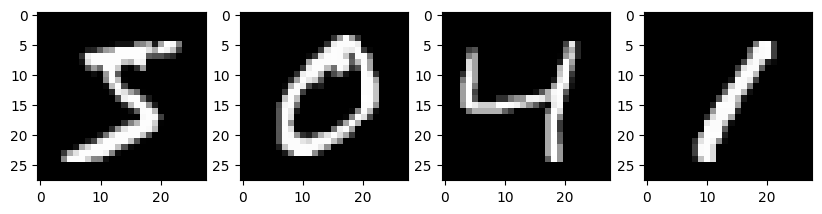

In [ ]:
# Display the first 4 images in the training data
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
for i in range(4):
    axes[i].imshow(X_train[i], cmap='gray')
plt.show()


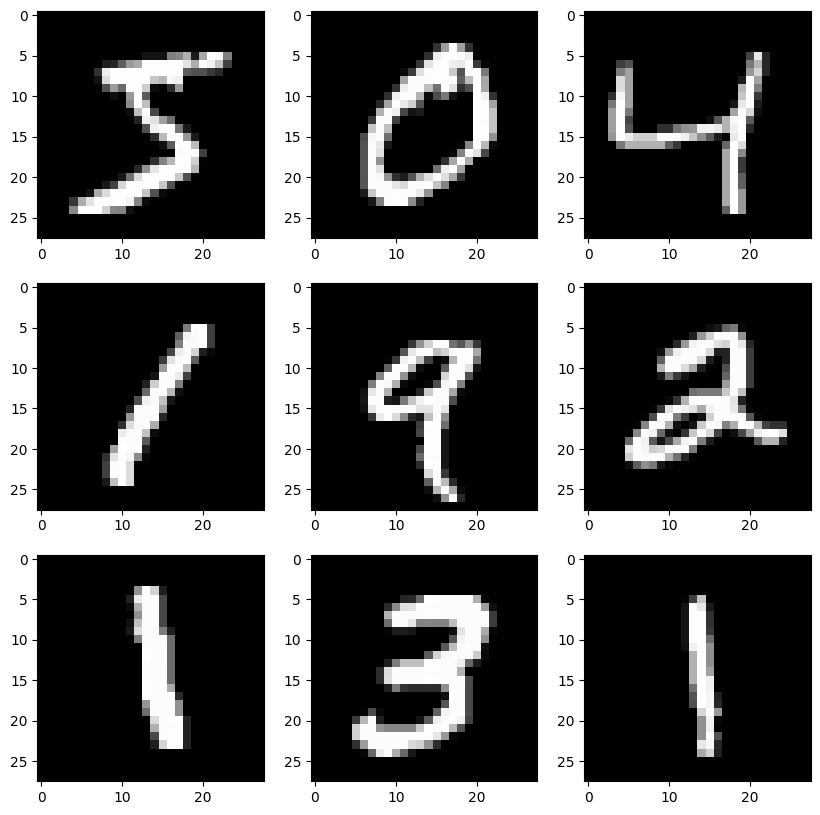

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(X_train[i], cmap='gray')
plt.show()


In [ ]:
# Function return digit in grayscale
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem #12 * 28 = 336
    
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax]) 
    plt.ylim([0, max_ax])
    plt.axis('off') #This function turns off the axis ticks and labels.
    black = '#000000' #means there is no red, green, or blue color, resulting in a black color
    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black) #maximum x and y coordinates would be 27 * 12 and 27 * 12
            c = digit[jdx][idx] / 255.  #The darker the pixel (i.e., the closer the grayscale value is to 0), the smaller the value of c, and the lighter the pixel (i.e., the closer the grayscale value is to 255), the larger the value of c
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
      
    plt.show()

t represents a single character of the digit image that we want to plot.

In the plot_digit function, t represents a single character of the digit image that we want to plot.

The line t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black')) sets the properties of a rectangular box that surrounds the character to make it stand out from the background.

(c, c, c)= three RGB color channels in facecolor

For example, if the pixel value of a character is 0 (black), then c will be 0 and the facecolor will be set to (0, 0, 0), which is black. Similarly, if the pixel value of a character is 255 (white), then c will be 1 and the facecolor will be set to (1, 1, 1), which is white. For all other pixel values, the facecolor will be set to a shade of gray that falls between black and white.

The facecolor argument sets the background color of the bounding box to a grayscale value that is determined by the pixel value of the character. The pixel value is normalized to a value between 0 and 1 by dividing it by 255. This creates a lighter or darker shade of gray depending on the pixel value.

The alpha argument sets the transparency of the bounding box to 0.5. This makes the text partially transparent so that the underlying image can still be seen through it.

The edgecolor argument sets the color of the border around the bounding box to black, so that it stands out from the surrounding image.







6


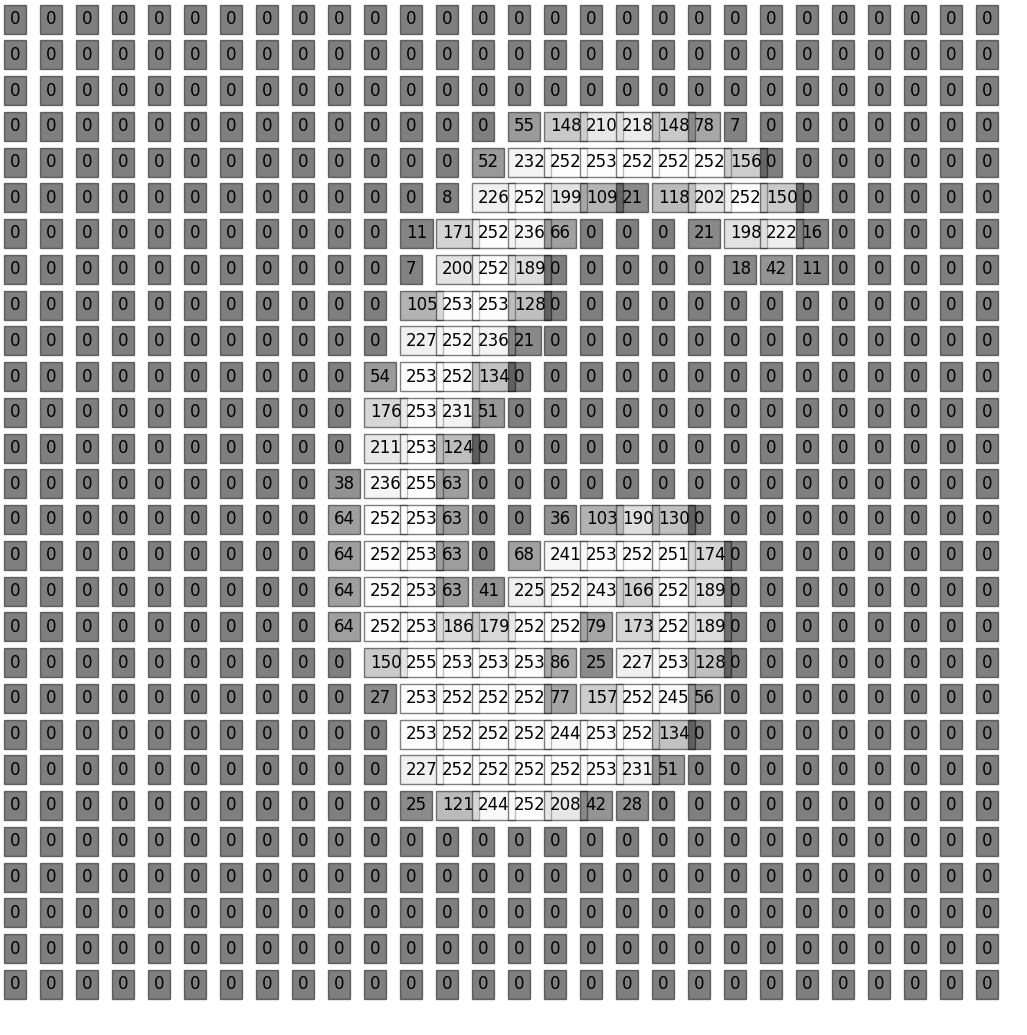

In [ ]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train[rand_number])

This code selects a random image from the training set (X_train_plot) and displays it using the plot_digit function. The corresponding label for the image is printed using y_train. This is useful for visually verifying that the label and the image correspond to each other.

# Chart of the number of digits in the data

This code is trying to show a bar chart that displays the number of occurrences of each digit in the training data.

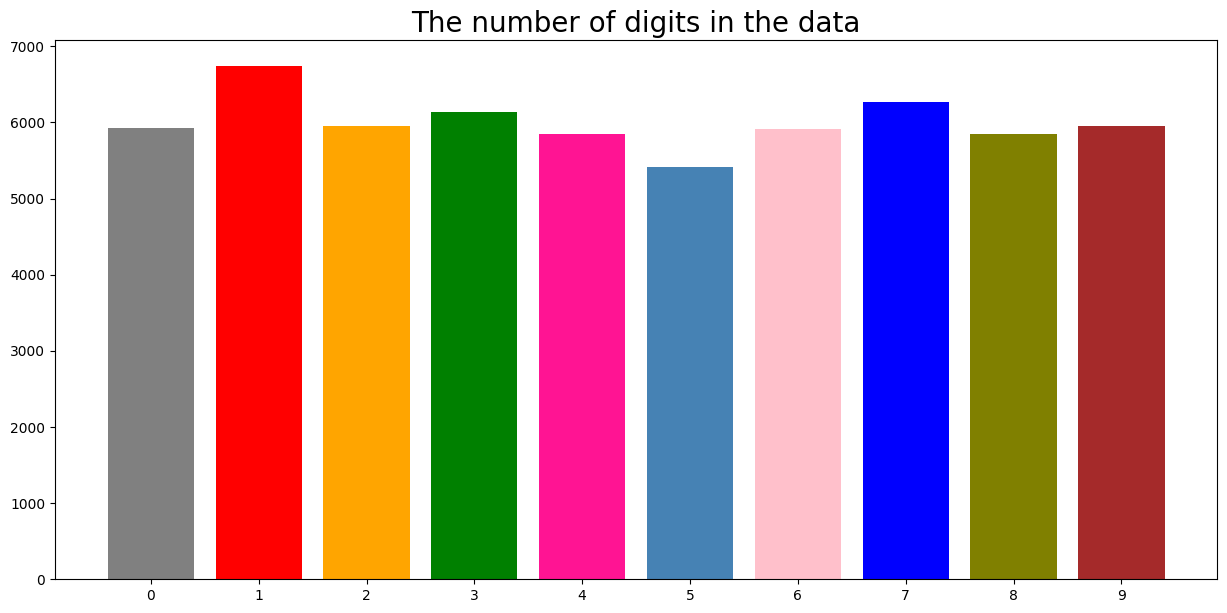

In [ ]:
digit_range = np.arange(10)

y_train_series = pd.Series(y_train) #to convert a NumPy array to a Pandas series
val = y_train_series.value_counts().index
cnt = y_train_series.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

# Data Preparing

In [ ]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
print(X_train.shape,X_test.shape)

(60000, 784) (10000, 784)


In [ ]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1] 

input_shape = (img_rows, img_cols)

In [ ]:
num_pixels

784

In [ ]:
y_train.shape

(60000,)

In [ ]:
# Data Normalization [0, 1]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = X_test.reshape(-1,28*28)

#num_classes = 10
# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]


# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000, 10) (10000, 784)


In [ ]:
num_classes

10

# Split data

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2)


In [ ]:
X_train.shape

(54000, 784)

In [ ]:
y_train.shape

(54000, 10)

In [ ]:
y_val.shape

(6000, 10)

In [ ]:
X_val.shape

(6000, 784)

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon()) #recall value
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
      

**The F1 score is a commonly used metric to evaluate the performance of a classification model**. It is the harmonic mean of precision and recall, which combines both metrics to provide a more balanced evaluation. In other words, F1 score considers both false positives and false negatives, which makes it a useful metric in scenarios where both precision and recall are important. **A high F1 score indicates good precision and recall, whereas a low F1 score indicates poor performance of the model**. By calculating the F1 score, we can understand how well our model is performing in terms of correctly classifying instances.


**F1 score is a weighted average of precision and recall, where F1 score reaches its best value at 1 and worst at 0.** It combines the precision and recall metrics to provide a single measure of performance.

Precision measures how many of the samples predicted as positive are actually positive. It is the ratio of true positives to the sum of true positives and false positives.

F1 score is calculated based on both precision and recall. In order to calculate F1 score, we need to have precision and recall values. F1 score is defined as the harmonic mean of precision and recall, which takes both precision and recall into account.

Therefore, precision is one of the metrics used to calculate the F1 score, and it plays an important role in determining the overall performance of a model.\

Function to drawing learning curve history learning neural network

In [ ]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

## Adding Callbacks
EarlyStopping (Stop training when a monitored metric has stopped improving)
ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)
ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)

Callbacks can be used in deep learning models for various purposes, such as:

**Saving the best model:** You can use a callback to save the weights of the best-performing model during training. The callback can monitor a validation metric, and whenever a new best model is found, it can save the model's weights to disk.

**Early stopping:** You can use a callback to stop training early if the validation metric has not improved for a certain number of epochs. This can prevent the model from overfitting and save time by stopping training once the model's performance has plateaued.

**Learning rate scheduling:** You can use a callback to adjust the learning rate during training. For example, you can use a learning rate scheduler to gradually decrease the learning rate as training progresses, which can help the model converge faster and avoid getting stuck in a local minimum.

**Visualizing training metrics:** You can use a callback to plot training metrics during training, such as the loss and accuracy on the training and validation data. This can help you monitor the model's performance and identify potential issues, such as overfitting.

Overall, callbacks are a useful tool for monitoring and controlling the training process of deep learning models, and can help you improve the model's performance and efficiency.

**ReduceLROnPlateau** is a callback function in Keras that is used during training to automatically reduce the learning rate of the optimizer when the training has plateaued. This can be helpful in improving the convergence of the model during training.

The **monitor** argument specifies the metric that the function should monitor. In this case, it is set to 'loss', which means that the function will monitor the loss function of the model during training.

The **patience** argument specifies the number of epochs that the function should wait before reducing the learning rate if the monitored metric does not improve. In this case, the function will wait for 3 epochs before reducing the learning rate if the loss does not improve.

In summary, the **ReduceLROnPlateau function** is used to automatically adjust the learning rate of the optimizer during training in order to improve the convergence of the model, and the monitor and patience arguments are used to specify the metric to monitor and the number of epochs to wait before reducing the learning rate.**

**categorical_crossentropy** is a loss function used in multi-class classification problems where there are two or more classes. It measures the distance between the true class distribution and the predicted class distribution. The goal is to minimize this distance during training, so that the model can accurately predict the class of new, unseen data.

In the case of categorical_crossentropy, the true class distribution is represented as a one-hot encoded vector, and the predicted class distribution is a probability vector output by the model. The loss function calculates the cross-entropy between these two distributions.

The categorical cross-entropy loss function is commonly used in deep learning models that use softmax activation in the output layer for multi-class classification tasks.

In [ ]:
def callbacks(name): 
    return [ 
        EarlyStopping(monitor = 'loss', patience = 6), 
        ReduceLROnPlateau(monitor = 'loss', patience = 3), 
        ModelCheckpoint(f'../working/{name}.hdf5', save_best_only=True) # saving the best model
    ]

# CNN (Convolutional_neural_network)

First We need to reshape data.

In [ ]:
X_train.shape

(54000, 784)

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)
print(X_train.shape, X_val.shape, X_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
def get_cnn1():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
         Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

**padding='same' in convolutional neural networks:**

When you apply convolutional layers to an image, the size of the output feature maps will be smaller than the input image size. This is because the convolution operation involves sliding a small filter/kernel over the input image, and applying element-wise multiplication and sum operations to compute the output values.

In order to prevent information loss due to this operation, you can apply padding to the input image. Padding involves adding extra rows and columns of zeros around the edges of the image, which allows the output feature maps to have the same spatial dimensions as the input image.

**When you set padding='same', it means that you want to add padding to the input image such that the output feature maps have the same spatial dimensions as the input image. Specifically, the amount of padding will be determined by the size of the convolutional filter/kernel, such that the output feature maps will have the same number of rows and columns as the input image.**

In the specific case of image classification tasks, **the convolutional layers are usually responsible for extracting the features from the images**, while **the dense layers are responsible for making the final classification decision based on those features**. Therefore, the optimal number of neurons in the dense layers may depend on the complexity of the features that have been extracted by the convolutional layers. It is possible that for some simpler image classification tasks, a smaller number of neurons in the dense layer may be sufficient.

**Point**
Since **each filter reduces the spatial dimension by 2**, and there is no padding, the output of the second convolutional layer has spatial dimensions of 26x26. Therefore, the output shape of the second convolutional layer is (None, 26, 26, 32).



In [ ]:
model = get_cnn1()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                        

An **epoch** is a complete iteration through the entire dataset during the training process. The training process of a neural network involves passing the input data through the network, computing the output, comparing it with the ground truth, and adjusting the parameters of the network to minimize the error. This process is done in batches, where a batch is a subset of the dataset.

In [ ]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 50, #total number of batch 422
          verbose = 1,
          callbacks = callbacks('cnn_v1'),
          validation_data = (X_val, y_val))

Epoch 1/50
422/422 [==============================] - 20s 14ms/step - loss: 0.4148 - f1: 0.8487 - val_loss: 0.0559 - val_f1: 0.9822 - lr: 0.0010
Epoch 2/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0889 - f1: 0.9750 - val_loss: 0.0491 - val_f1: 0.9866 - lr: 0.0010
Epoch 3/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0664 - f1: 0.9816 - val_loss: 0.0361 - val_f1: 0.9897 - lr: 0.0010
Epoch 4/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0484 - f1: 0.9863 - val_loss: 0.0348 - val_f1: 0.9900 - lr: 0.0010
Epoch 5/50
422/422 [==============================] - 5s 11ms/step - loss: 0.0427 - f1: 0.9879 - val_loss: 0.0256 - val_f1: 0.9925 - lr: 0.0010
Epoch 6/50
422/422 [==============================] - 5s 11ms/step - loss: 0.0374 - f1: 0.9891 - val_loss: 0.0305 - val_f1: 0.9908 - lr: 0.0010
Epoch 7/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0342 - f1: 0.9899 - val_loss: 0.0293 - val_f1: 0.9911 - lr

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.03145641088485718
Test score: 0.9954248666763306
CNN Error: 0.46%


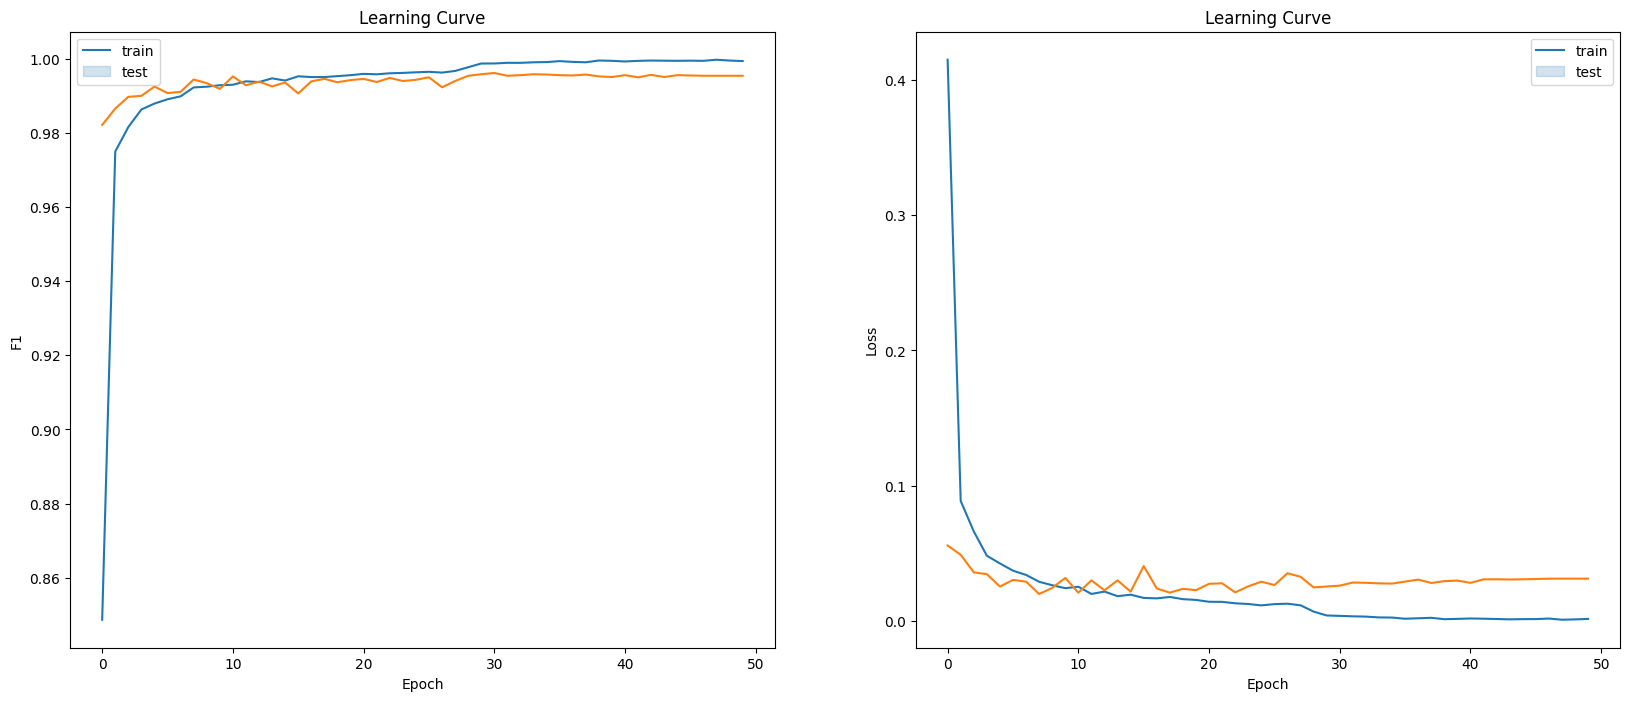

In [ ]:
draw_learning_curve(learning_history)

Let's see in which cases the model is invalid.

Let's assign the values provided by the model

In [ ]:
y_pred = model.predict(X_val)

188/188 [==============================] - 0s 2ms/step


In [ ]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    #x = np.ceil(np.sqrt(len(idx_nums)))
    x = int(np.ceil(np.sqrt(len(idx_nums))))

    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_val[ph]
        
        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_val[ph]), ph), fontsize = 10) 
        plt.bar(range(10), y_pred[ph])
        cnt += 1
         

The number of errors for the each digit

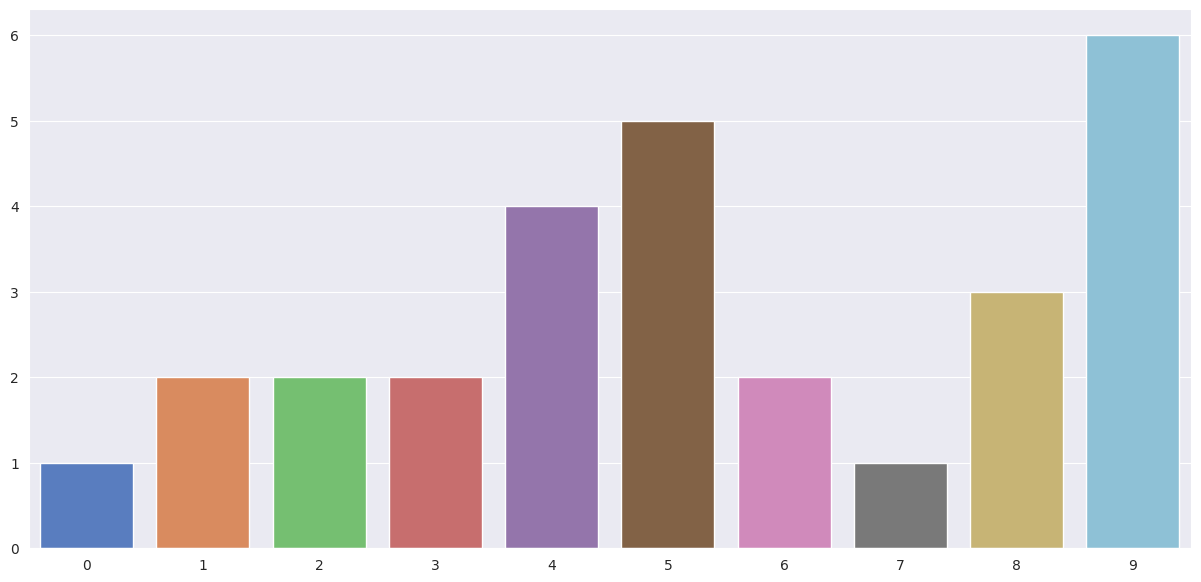

In [ ]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    cnt_error.append( (np.argmax(a)) )

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
bar_plot = sns.barplot(x=cnt_error[0], y=cnt_error[1], palette="muted")
plt.show()

Let's see these photos (2, 9)

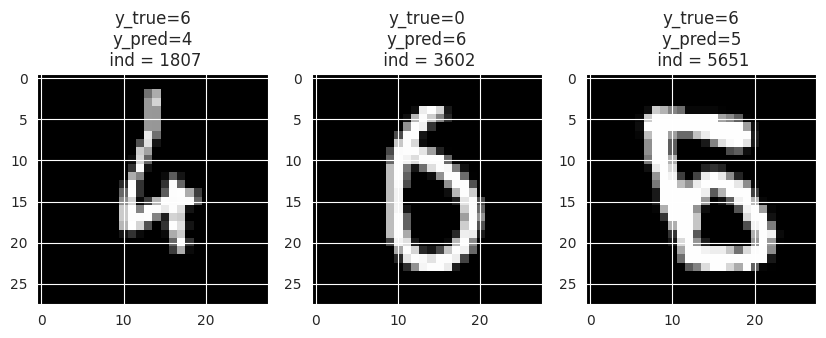

In [ ]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a) == 0 or np.argmax(a) == 6):    
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1
        

This code seems to be generating a plot of misclassified images from a validation dataset

The code is designed to loop through the true and predicted labels for each image in the validation set, and if the predicted label is different from the true label, it displays the corresponding image and adds the index to the list_idx list. The title of each subplot shows the true label, predicted label, and index of the misclassified image. By examining this list of misclassified image indices, you can determine which predictions were incorrect and investigate why the model made those errors.

<ipython-input-33-40b5366bd2d4>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(x, x, cnt)


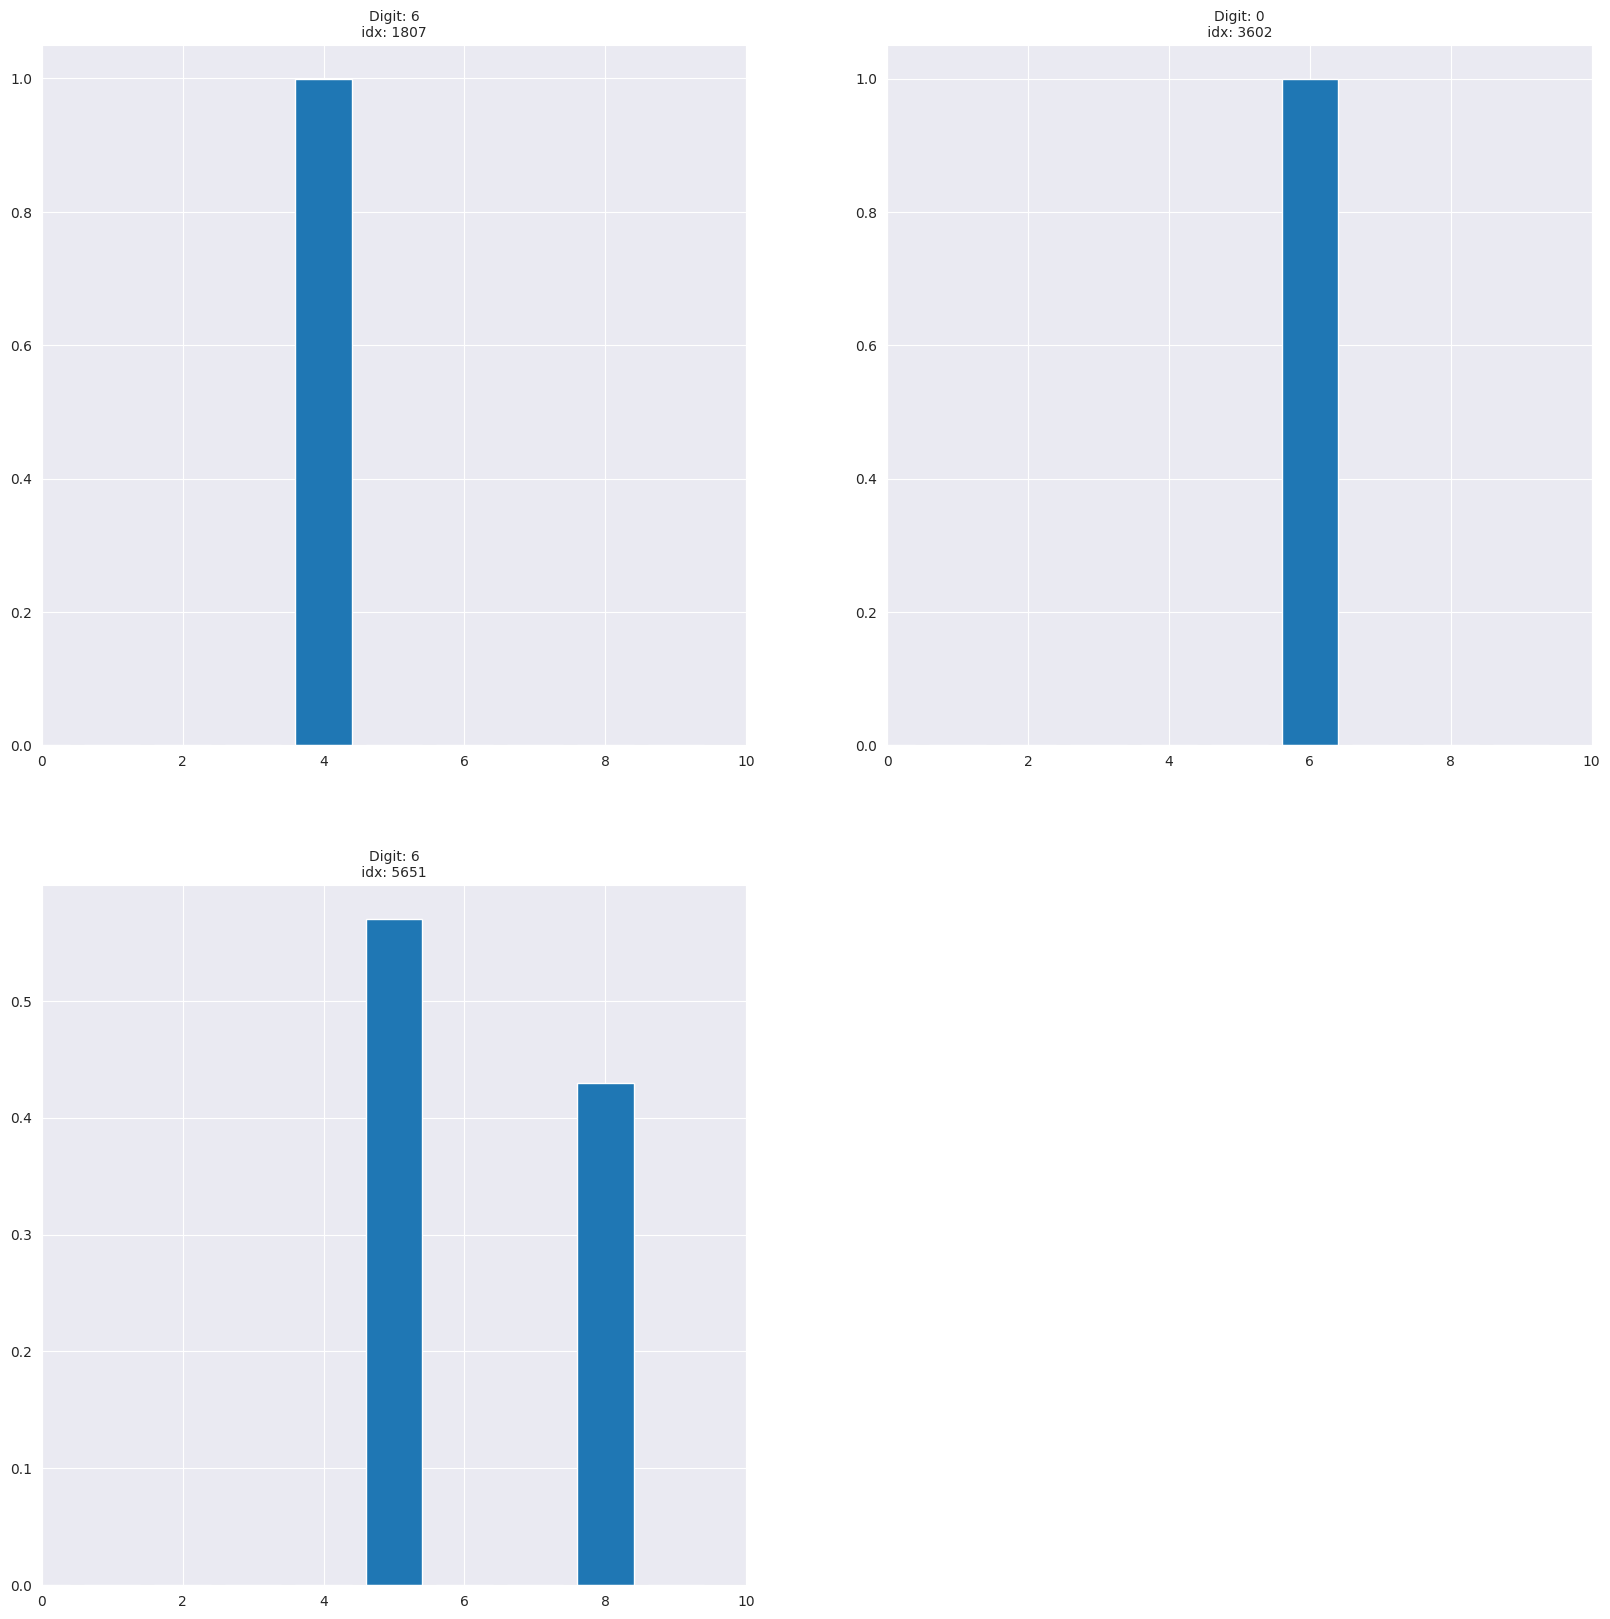

In [ ]:
draw_output(list_idx)

**Data Augmentation**

Data augmentation:
Randomly shift images horizontally by 10% of the width

Randomly shift images vertically by 10% of the height

Randomly rotate images by 10 degrees

Randomly Zoom by 10% some images

In [ ]:
train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

train_aug.fit(X_train)
train_gen = train_aug.flow(X_train, y_train, batch_size=64)

Building new model and using batch normalization

In [ ]:
def get_cnn_v2():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
                Flatten(),
          
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation = "softmax")
         ])

In [ ]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)       

In [ ]:
learning_history = model.fit_generator(train_gen, epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('best_cnn'),
                             )

Epoch 1/100


<ipython-input-41-041a049c1b7e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history = model.fit_generator(train_gen, epochs = 100,


843/843 [==============================] - 33s 31ms/step - loss: 0.5225 - f1: 0.8250 - val_loss: 0.0773 - val_f1: 0.9768 - lr: 0.0010
Epoch 2/100
843/843 [==============================] - 25s 30ms/step - loss: 0.1378 - f1: 0.9613 - val_loss: 0.0605 - val_f1: 0.9824 - lr: 0.0010
Epoch 3/100
843/843 [==============================] - 26s 31ms/step - loss: 0.1021 - f1: 0.9718 - val_loss: 0.0427 - val_f1: 0.9866 - lr: 0.0010
Epoch 4/100
843/843 [==============================] - 25s 30ms/step - loss: 0.0847 - f1: 0.9762 - val_loss: 0.0684 - val_f1: 0.9825 - lr: 0.0010
Epoch 5/100
843/843 [==============================] - 25s 30ms/step - loss: 0.0794 - f1: 0.9786 - val_loss: 0.0312 - val_f1: 0.9918 - lr: 0.0010
Epoch 6/100
843/843 [==============================] - 25s 29ms/step - loss: 0.0679 - f1: 0.9819 - val_loss: 0.0402 - val_f1: 0.9899 - lr: 0.0010
Epoch 7/100
843/843 [==============================] - 25s 30ms/step - loss: 0.0626 - f1: 0.9831 - val_loss: 0.0349 - val_f1: 0.9898 - l

**steps_per_epoch** is a parameter that is used in Keras during the training of a neural network. It tells Keras how many batches of data to process before considering one epoch (full pass through the training data).

In this example, **X_train.shape[0] is the number of training examples in the dataset**, and **// 64 is the integer division of that number by the batch size of 64**. This gives the number of batches of data that can be created from the training data, each of size 64.

So steps_per_epoch is simply the number of batches that Keras will process before completing one epoch during training. It helps to ensure that the entire training dataset is used equally during each epoch of training.

**Loading the best model**

In [ ]:

model.save(os.path.join('/content/drive/MyDrive/1-CNN-HandwritingClassification','1-CNN-HandwritingClassification.h5'))

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))


Test loss: 0.014392352662980556
Test score: 0.9957520365715027
CNN Error: 0.42%


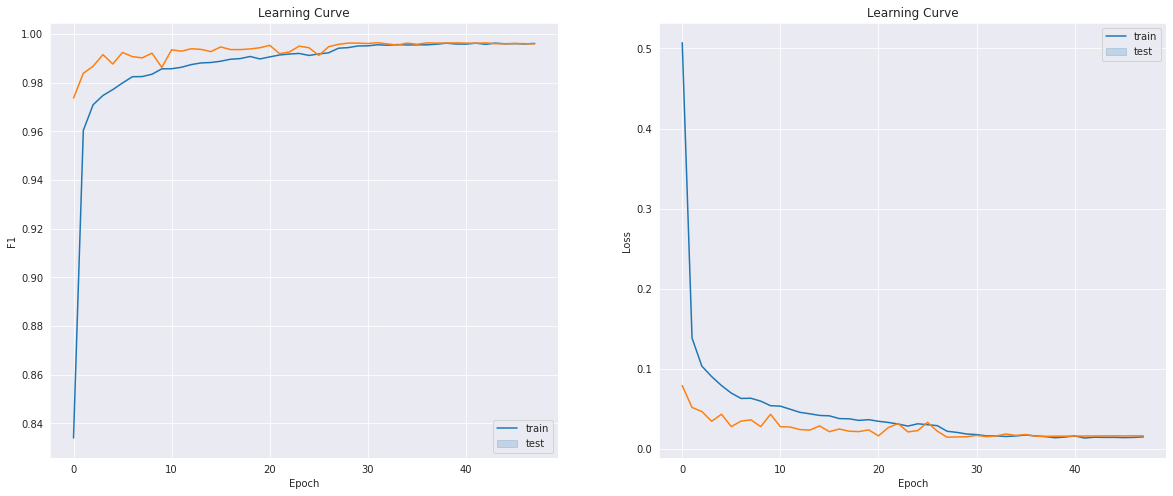

In [ ]:
draw_learning_curve(learning_history)

**Generate output**

In [ ]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("submission.csv", index=False)

313/313 [==============================] - 1s 3ms/step


In [ ]:
y_pred = model.predict(X_val)

188/188 [==============================] - 1s 3ms/step


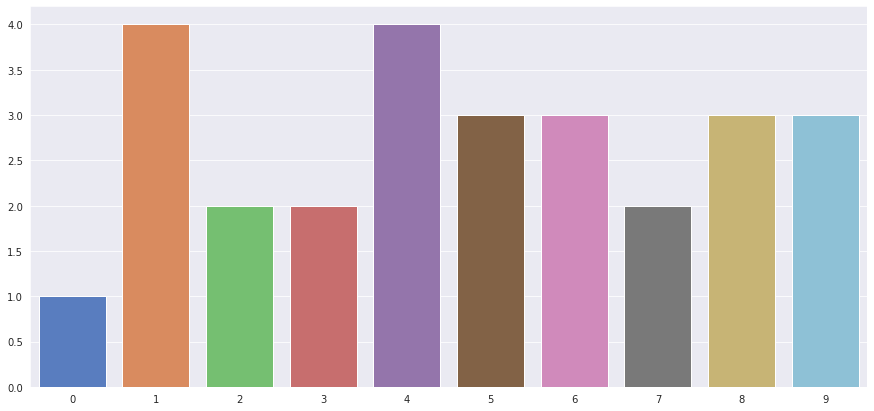

In [ ]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    cnt_error.append( (np.argmax(a)) )

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
bar_plot = sns.barplot(x=cnt_error[0], y=cnt_error[1], palette="muted")
plt.show()

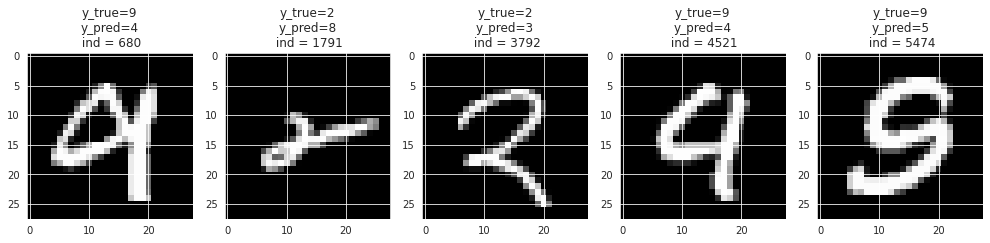

In [ ]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a) == 2 or np.argmax(a) == 9):    
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1